In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
# To ensure reproducibility and consistent results across runs
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST("./data", train=True, transform=transform, download=True)
test_dataset  = datasets.FashionMNIST("./data", train=False, transform=transform, download=True)

train_size = int(0.9 * len(train_dataset))
val_size   = len(train_dataset) - train_size

train_subset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Total training images: {len(train_dataset)}")
print(f"Training subset images: {len(train_subset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")

classes = train_dataset.classes

Total training images: 60000
Training subset images: 54000
Validation images: 6000
Test images: 10000


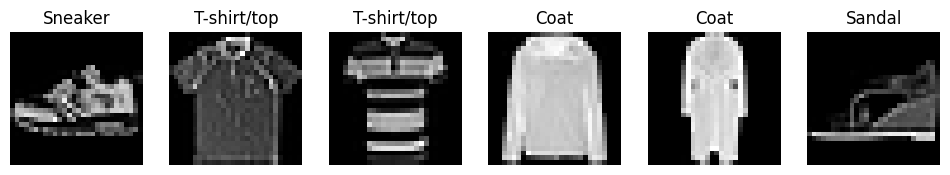

In [4]:
def show_samples():
    images, labels = next(iter(train_loader))
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap="gray")
        axes[i].set_title(classes[labels[i]])
        axes[i].axis("off")
    plt.show()

show_samples()

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class CNNWithAttention(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # ------ CONV FEATURE EXTRACTOR ------
        self.conv1 = nn.Sequential(
            ConvBlock(1, 64),
            ConvBlock(64, 64)
        )

        self.conv2 = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128)
        )

        self.conv3 = nn.Sequential(
            ConvBlock(128, 256),
            ConvBlock(256, 256)
        )

        self.pool = nn.MaxPool2d(2, 2)

        # ------ SELF-ATTENTION ------
        self.attn = nn.MultiheadAttention(
            embed_dim=256,
            num_heads=4,
            batch_first=True
        )

        # ------ CLASSIFIER ------
        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # conv block 1 → 28×28 → 14×14
        x = self.conv1(x)
        x = self.pool(x)

        # conv block 2 → 14×14 → 7×7
        x = self.conv2(x)
        x = self.pool(x)

        # conv block 3 → 7×7
        x = self.conv3(x)

        # reshape for attention: (B, C, H*W)
        B, C, H, W = x.shape
        x = x.view(B, C, H * W).transpose(1, 2)   # (B, 49, 256)

        # self-attention
        x, _ = self.attn(x, x, x)

        # global average pooling on sequence
        x = x.mean(dim=1)

        # final classifier
        return self.classifier(x)



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CNNWithAttention().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [7]:
patience = 5              # number of epochs to wait for improvement
best_val_loss = np.inf
epochs_no_improve = 0
max_epochs = 1000         # just a safety limit
best_model_state = None

for epoch in range(1, max_epochs + 1):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # -------- Validation Step --------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:   # Make sure you have a val_loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -------- Early Stopping Logic --------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("\nEarly stopping triggered!")
        print(f"Best Validation Loss: {best_val_loss:.4f}")
        break

# Load the best model state
model.load_state_dict(best_model_state)
print("Restored best model parameters.")

Epoch 1 | Train Loss: 0.4923 | Val Loss: 0.3272
Epoch 2 | Train Loss: 0.2931 | Val Loss: 0.2995
Epoch 3 | Train Loss: 0.2449 | Val Loss: 0.2469
Epoch 4 | Train Loss: 0.2159 | Val Loss: 0.2441
Epoch 5 | Train Loss: 0.1970 | Val Loss: 0.2267
Epoch 6 | Train Loss: 0.1767 | Val Loss: 0.1986
Epoch 7 | Train Loss: 0.1565 | Val Loss: 0.2212
  No improvement for 1 epoch(s).
Epoch 8 | Train Loss: 0.1420 | Val Loss: 0.2183
  No improvement for 2 epoch(s).
Epoch 9 | Train Loss: 0.1297 | Val Loss: 0.2288
  No improvement for 3 epoch(s).
Epoch 10 | Train Loss: 0.1121 | Val Loss: 0.2095
  No improvement for 4 epoch(s).
Epoch 11 | Train Loss: 0.0968 | Val Loss: 0.2584
  No improvement for 5 epoch(s).

Early stopping triggered!
Best Validation Loss: 0.1986
Restored best model parameters.


In [8]:
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

mis_images = []
mis_preds = []
mis_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for img, pred, label in zip(images, predicted, labels):
            if pred != label:
                mis_images.append(img.cpu())
                mis_preds.append(pred.item())
                mis_labels.append(label.item())

accuracy = 100 * correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 92.26%
Test F1 Score: 0.9206


<Figure size 1600x1200 with 0 Axes>

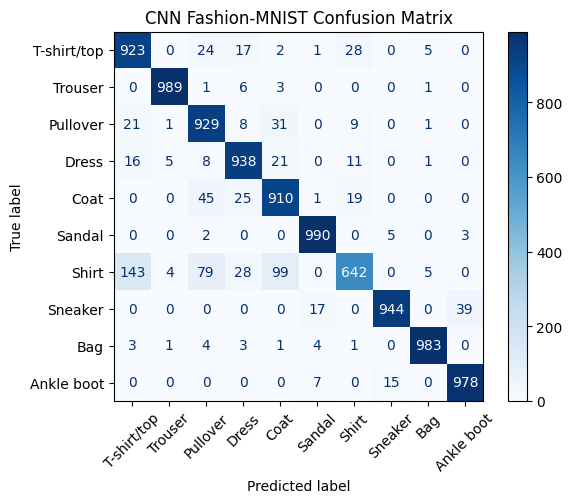

In [9]:

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(16, 12))
disp.plot(cmap="Blues", values_format="d")
plt.xticks(rotation=45)
plt.title("CNN Fashion-MNIST Confusion Matrix")
plt.show()


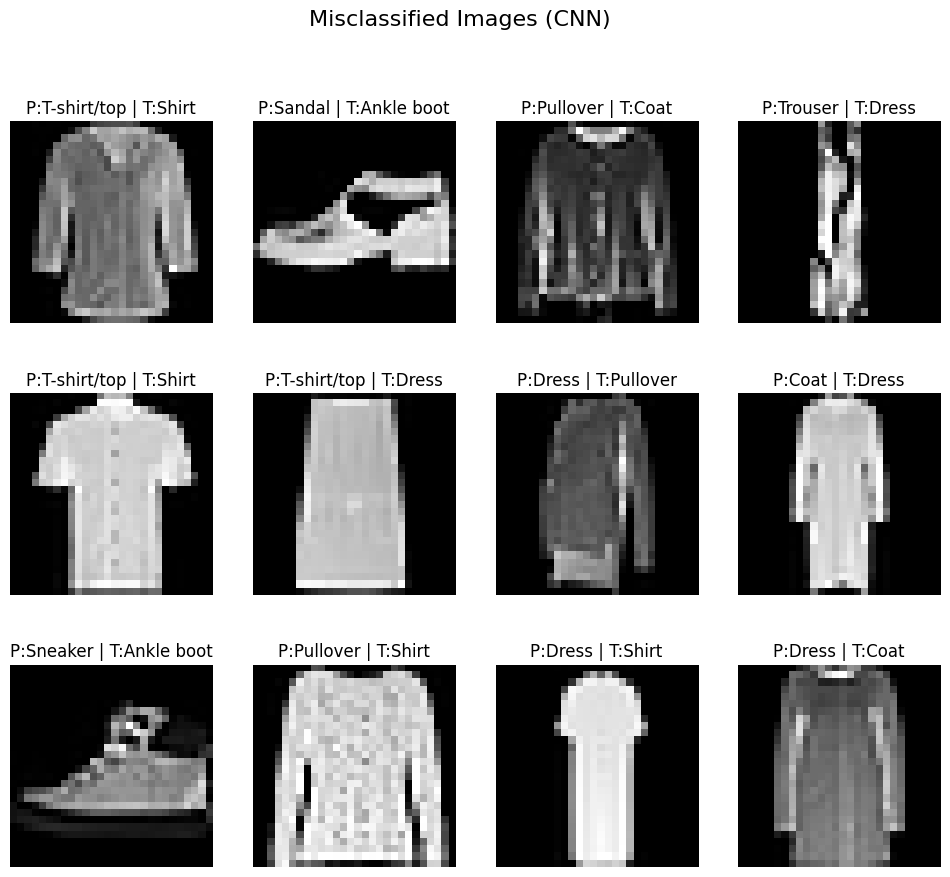

In [10]:

plt.figure(figsize=(12, 10))
num = 12
classes = train_dataset.classes

for i in range(num):
    plt.subplot(3, 4, i+1)
    plt.imshow(mis_images[i].squeeze(), cmap="gray")
    plt.title(f"P:{classes[mis_preds[i]]} | T:{classes[mis_labels[i]]}")
    plt.axis("off")

plt.suptitle("Misclassified Images (CNN)", fontsize=16)
plt.show()


In [11]:
class VisionTransformer(nn.Module):
    """
    Option 2:
    Vision Transformer (ViT) for 28x28 images.
    """

    def __init__(self, patch_size=7, embed_dim=128, depth=4, num_heads=4, mlp_dim=256):
        super().__init__()

        self.patch_size = patch_size
        num_patches = (28 // patch_size) ** 2

        # ---- Patch Embedding ----
        self.patch_embed = nn.Linear(patch_size * patch_size, embed_dim)

        # ---- Position Embedding ----
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        # ---- CLS Token ----
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # ---- Transformer Encoder Blocks ----
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads,
            dim_feedforward=mlp_dim, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # ---- Classifier ----
        self.fc = nn.Linear(embed_dim, 10)

    def forward(self, x):
        B = x.size(0)
        x = x.squeeze(1)  # (B, 28, 28)

        # Split into patches
        patches = x.unfold(1, self.patch_size, self.patch_size) \
                    .unfold(2, self.patch_size, self.patch_size)  # (B, 4, 4, 7, 7)

        patches = patches.contiguous().view(B, -1, self.patch_size * self.patch_size)  # (B, 16, 49)

        # Patch embedding
        x = self.patch_embed(patches)  # (B, 16, embed_dim)

        # Add CLS token
        cls = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat([cls, x], dim=1)          # (B, 17, embed_dim)

        # Add positional embedding
        x = x + self.pos_embed[:, :x.size(1)]

        # Transformer encoder
        x = self.transformer(x)

        # Use CLS token
        cls_out = x[:, 0]

        return self.fc(cls_out)



In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [13]:
patience = 5              # number of epochs to wait for improvement
best_val_loss = np.inf
epochs_no_improve = 0
max_epochs = 1000         # just a safety limit
best_model_state = None

for epoch in range(1, max_epochs + 1):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # -------- Validation Step --------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:   # Make sure you have a val_loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -------- Early Stopping Logic --------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("\nEarly stopping triggered!")
        print(f"Best Validation Loss: {best_val_loss:.4f}")
        break

# Load the best model state
model.load_state_dict(best_model_state)
print("Restored best model parameters.")

Epoch 1 | Train Loss: 0.7088 | Val Loss: 0.5192
Epoch 2 | Train Loss: 0.4834 | Val Loss: 0.4338
Epoch 3 | Train Loss: 0.4484 | Val Loss: 0.4375
  No improvement for 1 epoch(s).
Epoch 4 | Train Loss: 0.4311 | Val Loss: 0.4162
Epoch 5 | Train Loss: 0.4157 | Val Loss: 0.4072
Epoch 6 | Train Loss: 0.4061 | Val Loss: 0.4042
Epoch 7 | Train Loss: 0.4043 | Val Loss: 0.3881
Epoch 8 | Train Loss: 0.3887 | Val Loss: 0.3937
  No improvement for 1 epoch(s).
Epoch 9 | Train Loss: 0.3977 | Val Loss: 0.4108
  No improvement for 2 epoch(s).
Epoch 10 | Train Loss: 0.3797 | Val Loss: 0.3997
  No improvement for 3 epoch(s).
Epoch 11 | Train Loss: 0.3756 | Val Loss: 0.3749
Epoch 12 | Train Loss: 0.3773 | Val Loss: 0.3849
  No improvement for 1 epoch(s).
Epoch 13 | Train Loss: 0.3712 | Val Loss: 0.3652
Epoch 14 | Train Loss: 0.3678 | Val Loss: 0.3761
  No improvement for 1 epoch(s).
Epoch 15 | Train Loss: 0.3676 | Val Loss: 0.3928
  No improvement for 2 epoch(s).
Epoch 16 | Train Loss: 0.3599 | Val Loss: 0

In [14]:
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

mis_images = []
mis_preds = []
mis_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for img, pred, label in zip(images, predicted, labels):
            if pred != label:
                mis_images.append(img.cpu())
                mis_preds.append(pred.item())
                mis_labels.append(label.item())

accuracy = 100 * correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 88.42%
Test F1 Score: 0.8840


<Figure size 1600x1200 with 0 Axes>

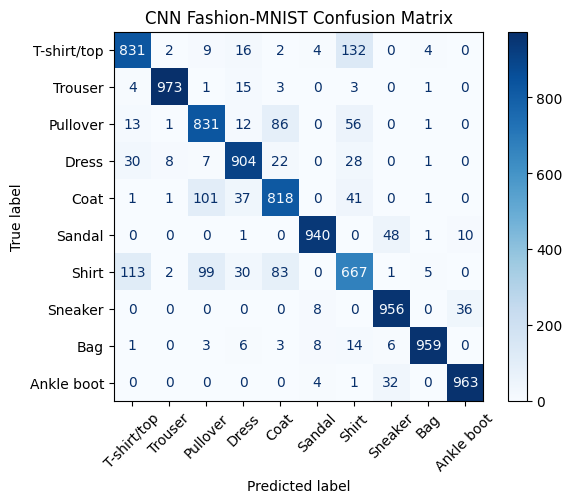

In [15]:

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(16, 12))
disp.plot(cmap="Blues", values_format="d")
plt.xticks(rotation=45)
plt.title("CNN Fashion-MNIST Confusion Matrix")
plt.show()


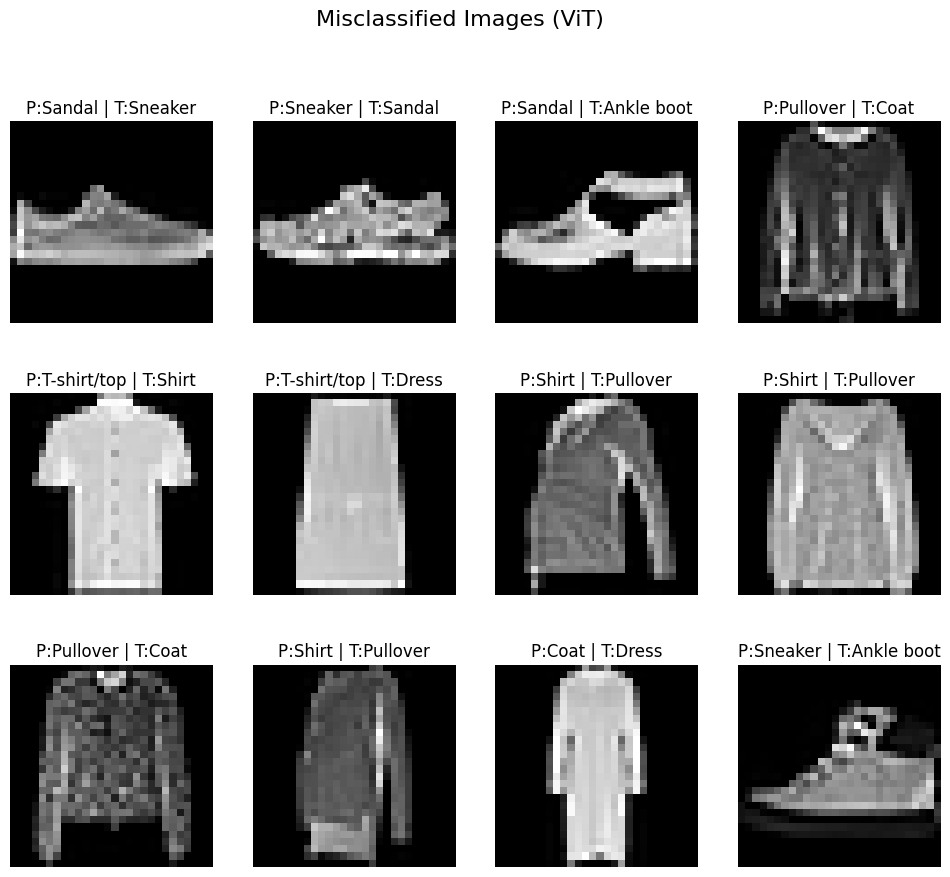

In [16]:

plt.figure(figsize=(12, 10))
num = 12

for i in range(num):
    plt.subplot(3, 4, i+1)
    plt.imshow(mis_images[i].squeeze(), cmap="gray")
    plt.title(f"P:{classes[mis_preds[i]]} | T:{classes[mis_labels[i]]}")
    plt.axis("off")

plt.suptitle("Misclassified Images (ViT)", fontsize=16)
plt.show()
